# Imports

In [2]:
# Dependencies
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, load_model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Activation, Input
from keras.optimizers import Adam
from IPython.display import Audio, HTML, Javascript, display
import IPython.display as ipd
from glob import glob
import music21
from pydub import AudioSegment
import joblib

color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]


### MFCC (Mel-frequency cepstral coefficients):

- MFCCs are one of the most widely used feature extraction techniques in audio signal processing, particularly for speech recognition tasks.
- They capture the spectral envelope of an audio signal.
- The process involves applying the discrete cosine transform (DCT) to the log power spectrum of the audio signal.
- MFCCs are effective in capturing the characteristics of human speech due to their ability to approximate the human auditory system's response to sound frequencies.

### Mel Spectrogram:

- The Mel spectrogram is a visual representation of the power spectrum of an audio signal, where the frequencies are converted to the Mel scale.
- It divides the frequency spectrum into Mel-frequency bands, which are spaced according to human perception of sound.
- Mel spectrograms provide a compact representation of the frequency content of an audio signal and are often used as input for machine learning models in tasks such as music genre classification and audio event detection.

### Chroma Features:

- Chroma features capture the pitch content of an audio signal by representing the distribution of energy across different pitch classes (e.g., musical notes).
- They are useful for tasks involving harmonic analysis and music similarity.
- Chroma features are invariant to changes in timbre and loudness, making them suitable for tasks such as music genre classification and chord recognition.

### Spectral Contrast:

- Spectral contrast measures the difference in energy between peaks and valleys in the frequency spectrum of an audio signal.
- It provides information about the spectral texture or timbre of the audio signal.
- Spectral contrast features are useful for tasks such as music genre classification, audio fingerprinting, and sound texture analysis.
ound texture analysis.

# Exploration & Visualization

In [5]:
# Load audio file and extract chroma features
audio_files = glob(r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\Resources\guitar-notes\Notes Datasets\*\*.wav')


In [6]:
ipd.Audio(audio_files[0])

In [7]:
y, sr = librosa.load(audio_files[0])  # Using librosa for audio processing and feature extraction
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-0.00033982 -0.00072839 -0.00090695 -0.00124933 -0.00158278 -0.0019285
 -0.0021079  -0.00201866 -0.00160286 -0.00113702]
shape y: (10968,)
sr: 22050


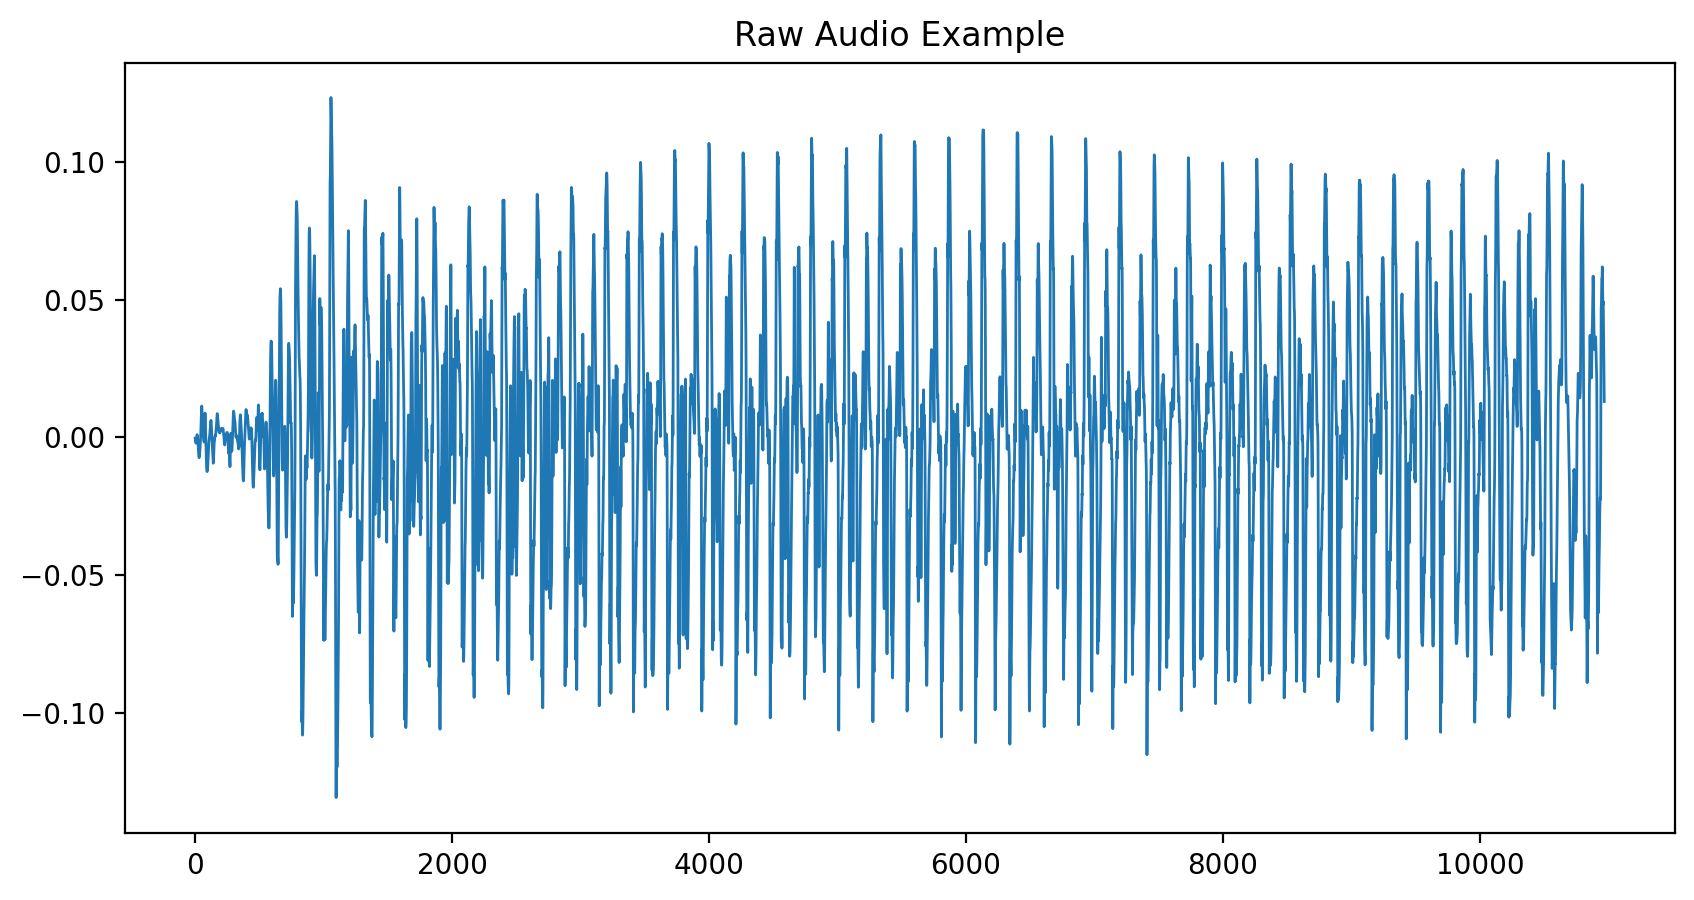

In [8]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

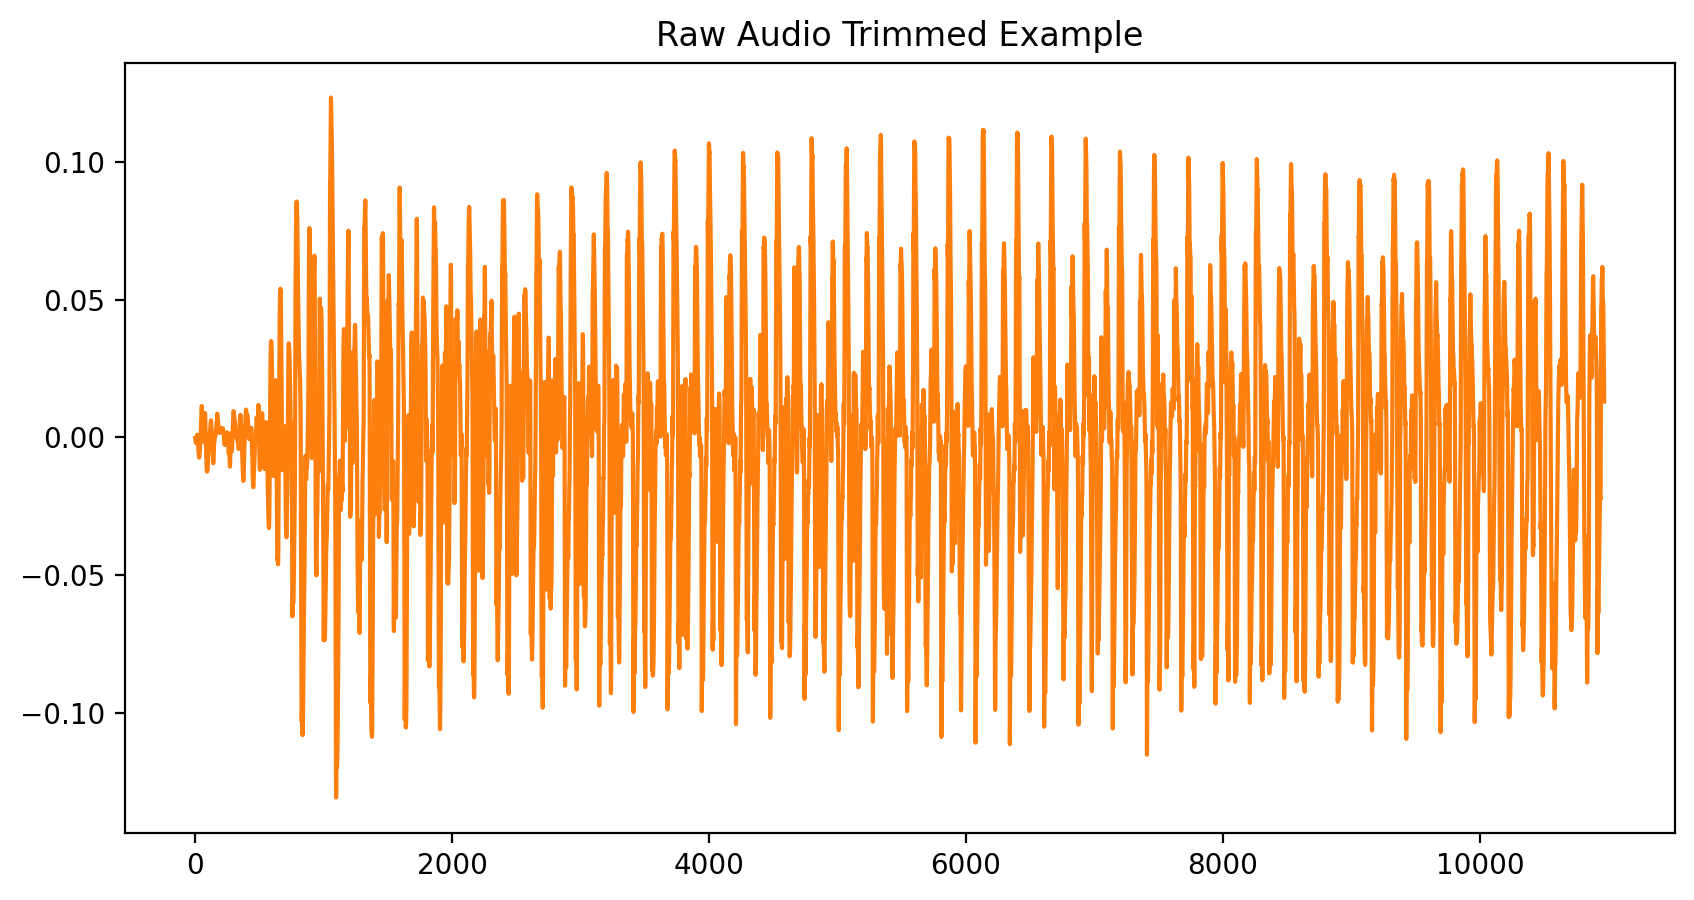

In [9]:
# Using librosa for audio processing and feature extraction
y_trimmed, _ = librosa.effects.trim(y, top_db=20) 
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  title='Raw Audio Trimmed Example',
                 color=color_pal[1])
plt.show()

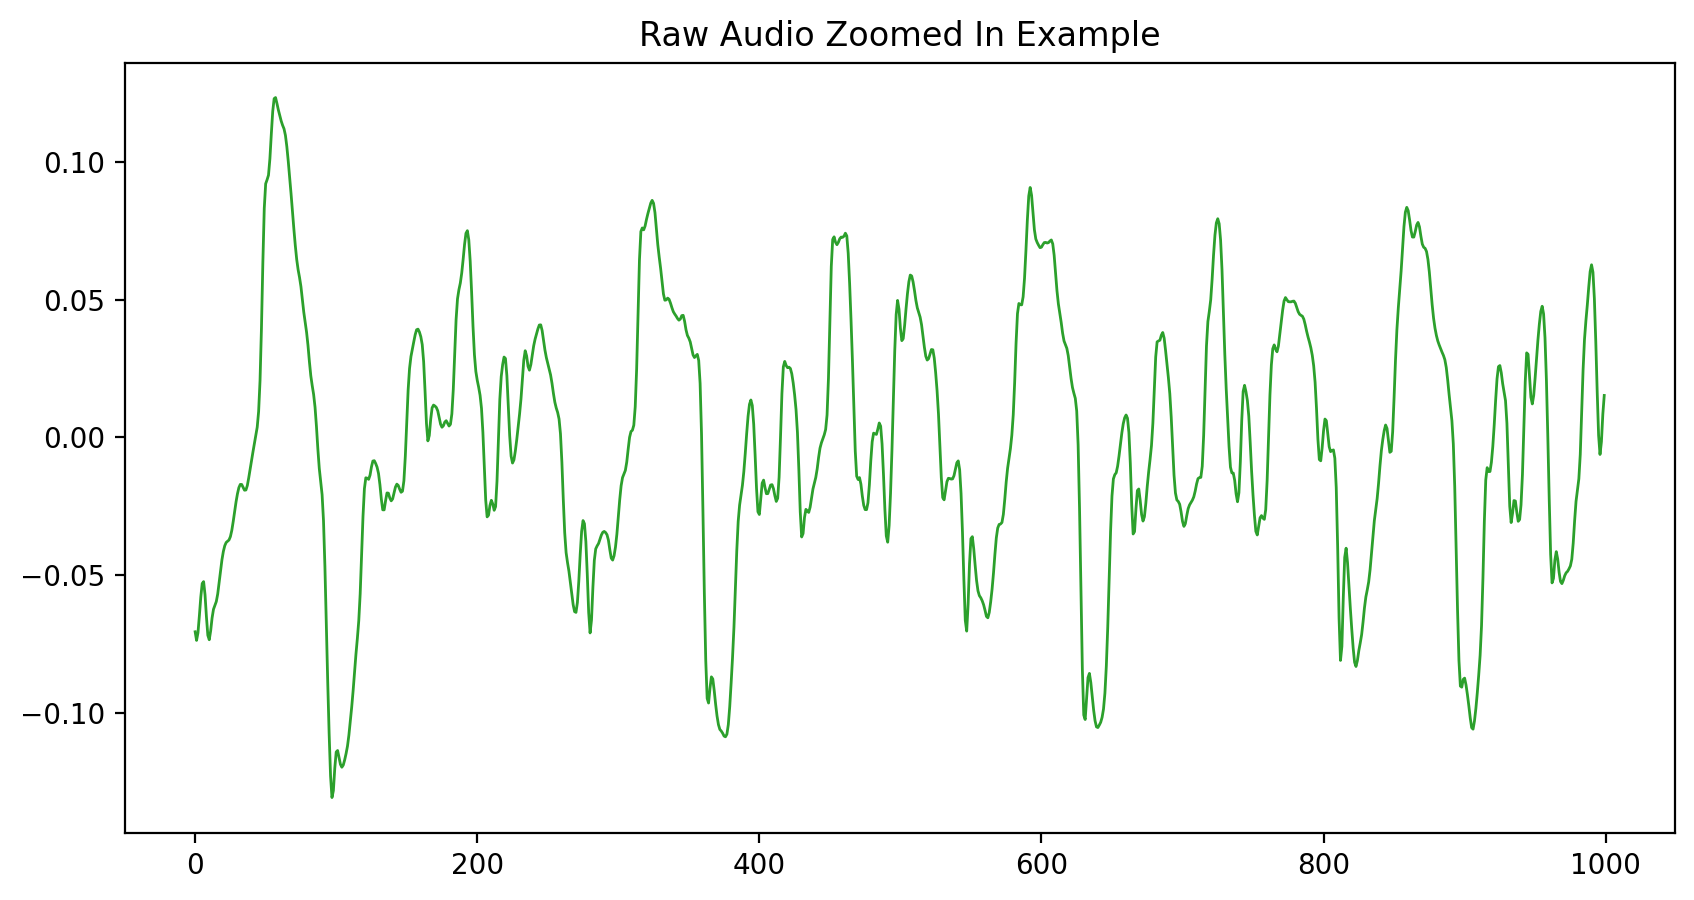

In [10]:
pd.Series(y[1000:2000]).plot(figsize=(10, 5), 
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

## Visualizing the features extraction methods: 

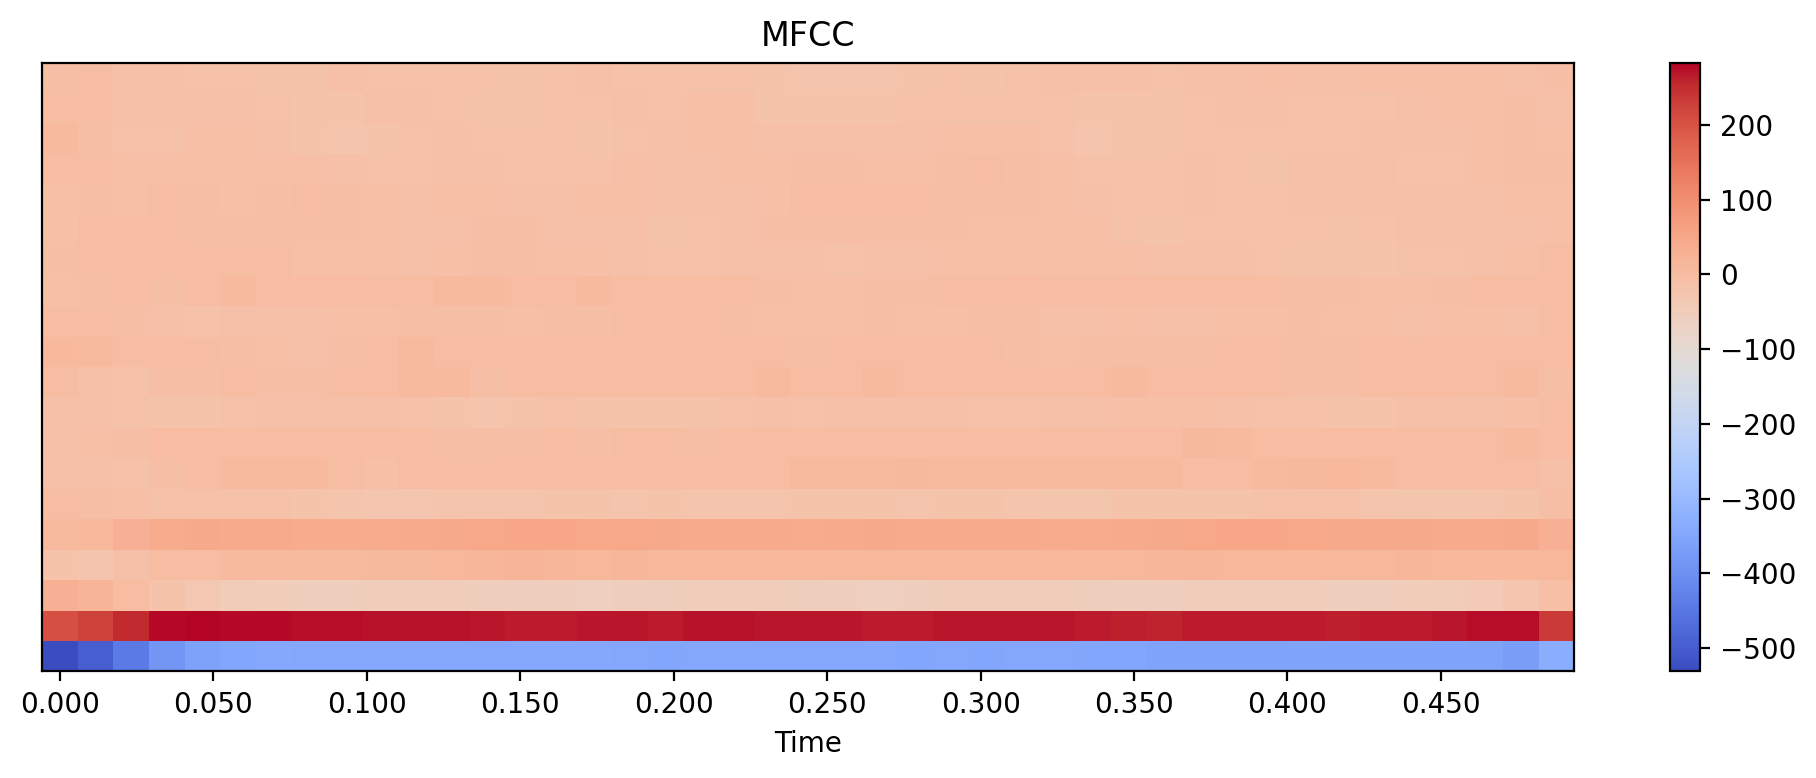

In [12]:
file_path = audio_files[0]
audio, sr = librosa.load(file_path, sr=None)
mfccs = librosa.feature.mfcc(y=audio, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

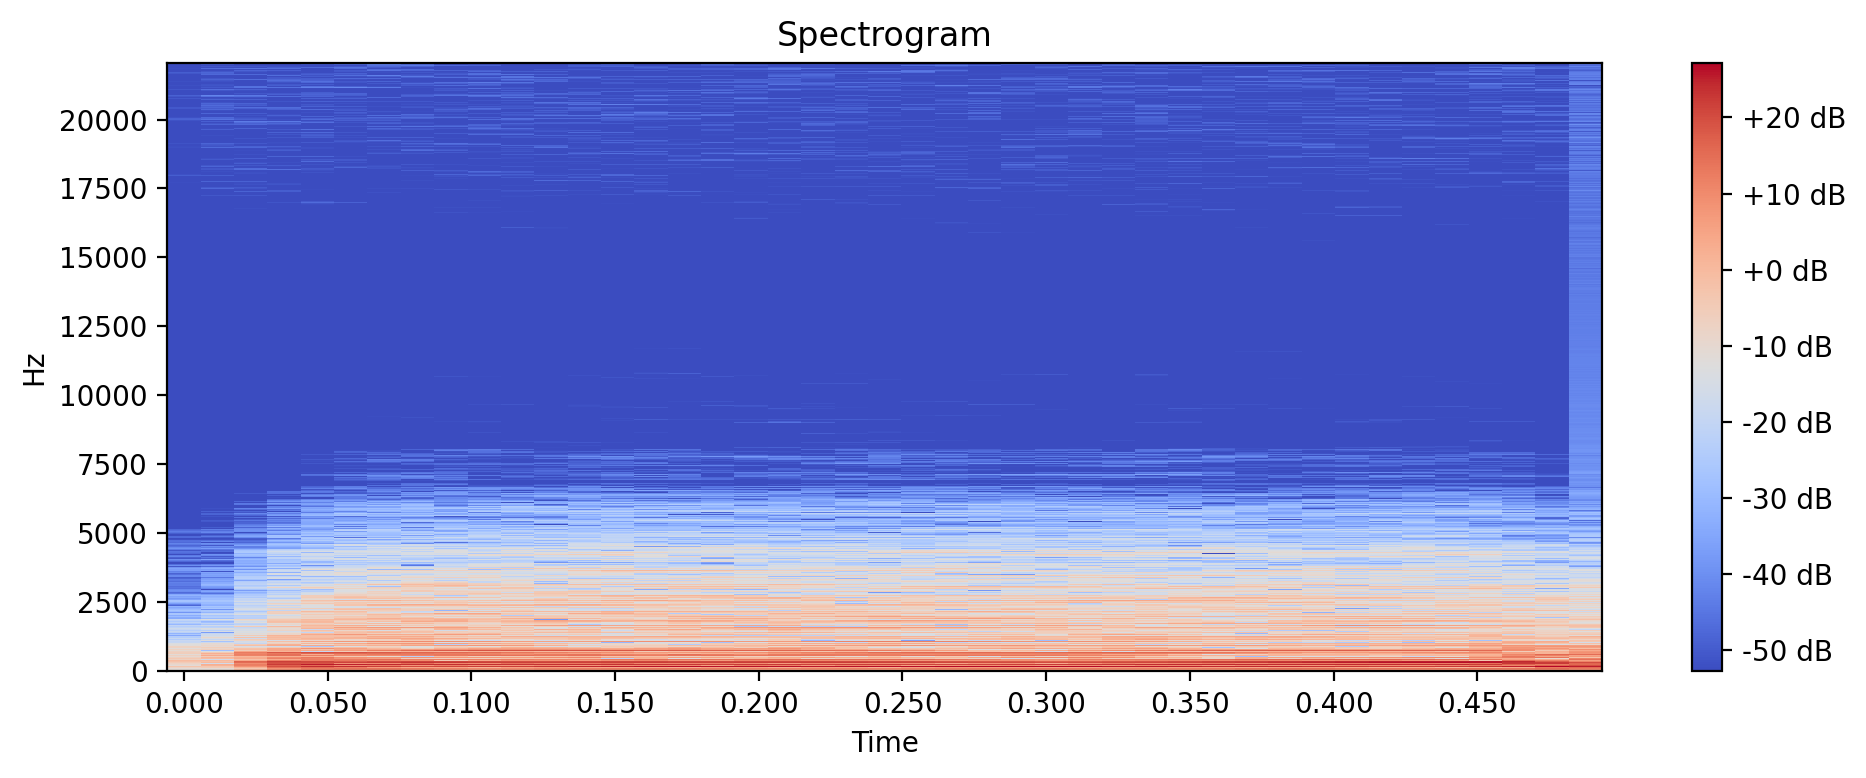

In [13]:
spectrogram = librosa.stft(audio)

spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='linear',fmax=8000)  # Using librosa for audio processing and feature extraction
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

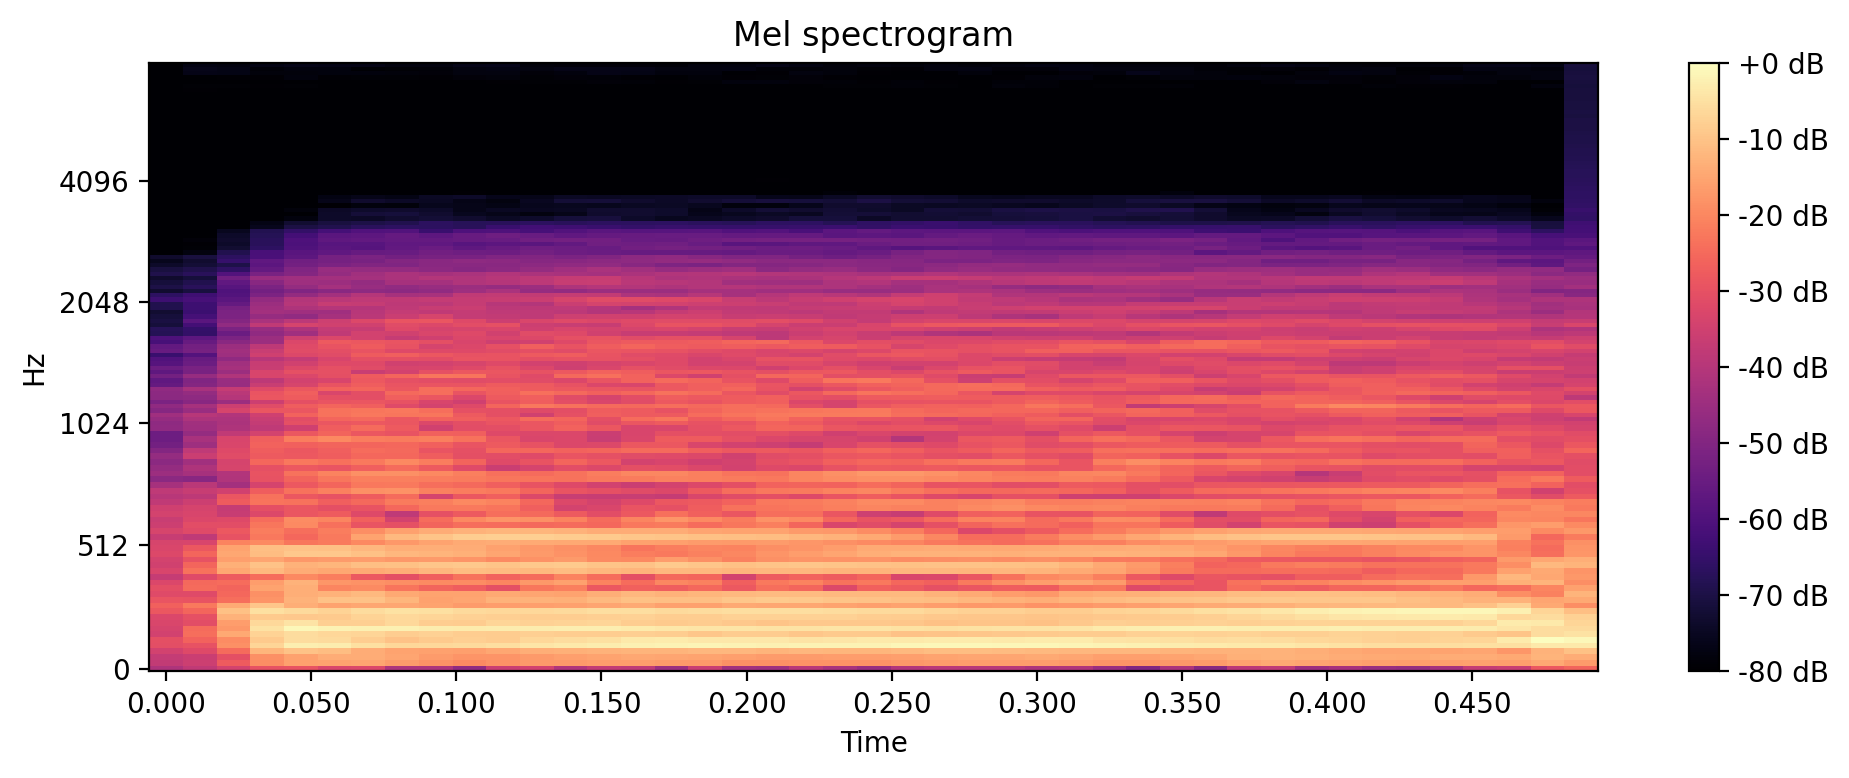

In [14]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)  
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=sr, y_axis='mel', fmax=8000, x_axis='time')  # Using librosa for audio processing and feature extraction
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

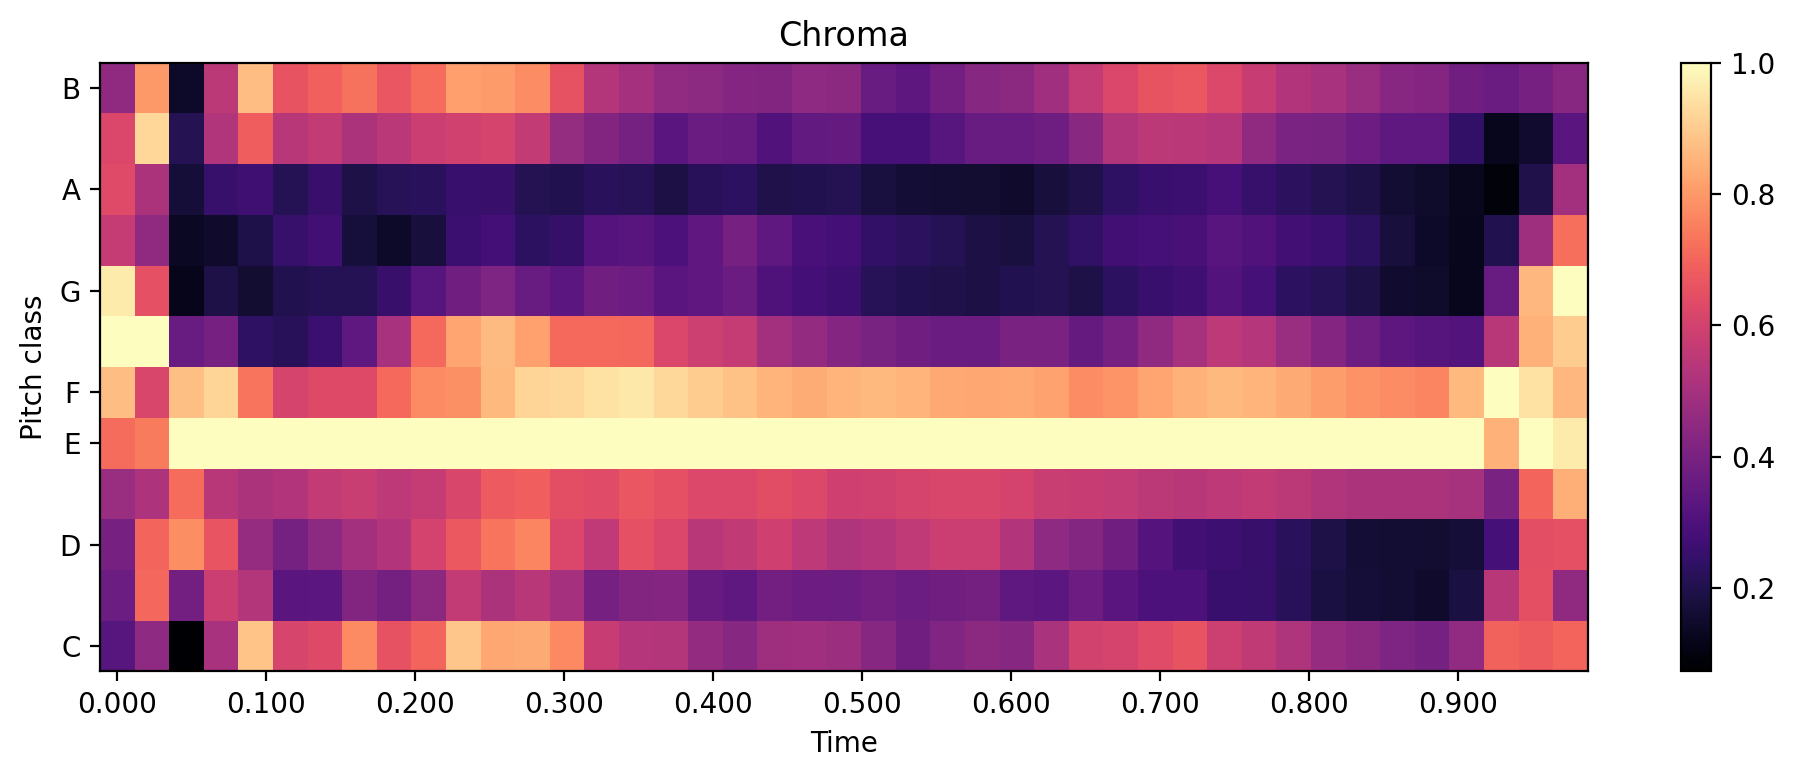

In [15]:
chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time') 
plt.colorbar()
plt.title('Chroma')
plt.tight_layout()
plt.show()

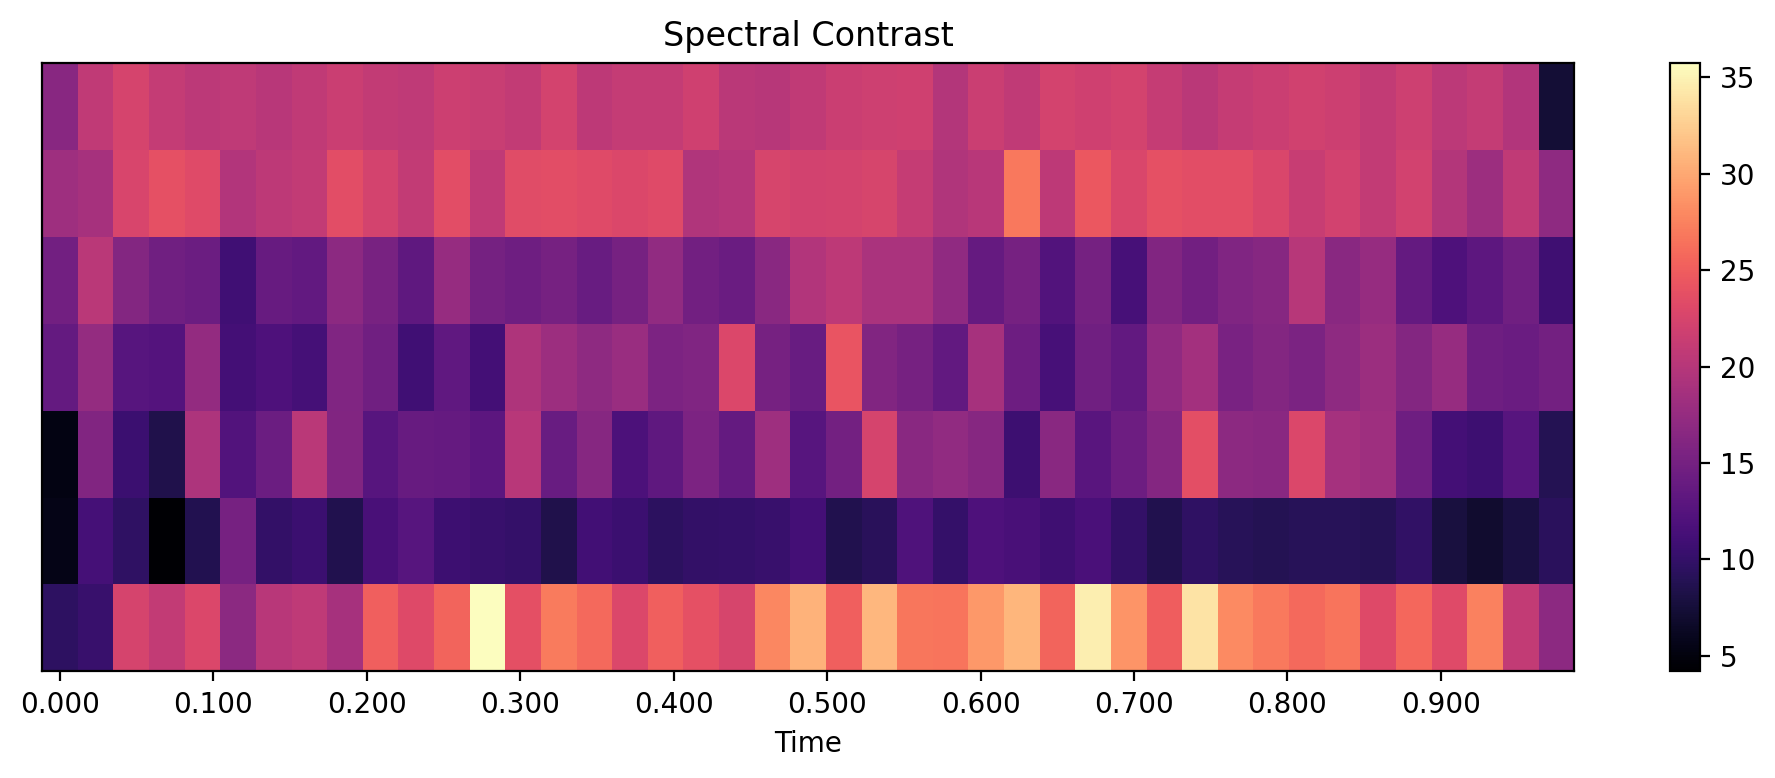

In [16]:
contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')
plt.tight_layout()
plt.show()

# Data Augmentation 

## Data Augmentation

Data augmentation enhances the diversity of training data by applying transformations. These techniques are valuable for audio tasks, improving model robustness and performance.

### Techniques:

1. **Add White Noise**: Introduce random noise to simulate real-world environments.

2. **Time Stretch**: Adjust duration without pitch alteration.

3. **Time Shift**: Vary timing for temporal robustness.

4. **Pitch Shift**: Simulate pitch changes for musical note variation.


In [19]:
# Load and preprocess the audio data
def add_white_noise(data, noise_level=0.005):
    max_amplitude = np.max(np.abs(data))
    noise_amp = noise_level * max_amplitude
    white_noise = noise_amp * np.random.normal(size=len(data))
    noisy_data = data + white_noise
    return noisy_data

def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def time_shift(data, max_shift_ms=50):
    shift_range = int(np.random.uniform(low=-max_shift_ms, high=max_shift_ms) * 1000)
    return np.roll(data, shift_range)

def random_pitch_shift(data, sr, pitch_range=(-2, 2)):
    pitch_shift_semitones = np.random.uniform(*pitch_range)
    pitch_factor = 2 ** (pitch_shift_semitones / 12.0)
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=pitch_factor)

# Preprocessing & Feature Extraction 

Define feature extraction function. We will use MFCC, Mel Spectogram,Chroma and Spectral features.

In [22]:
# Extract features from audio
def extract_features(file_path, num_mfcc=13, n_fft=2048, hop_length=512, mfcc_len=100):
    audio, sr = librosa.load(file_path, sr=None)    
    audio = add_white_noise(audio)
    audio = time_stretch(audio)
    audio = time_shift(audio)
    audio = random_pitch_shift(audio, sr)
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    
    if mfccs.shape[1] < mfcc_len:
        mfccs = np.pad(mfccs, ((0, 0), (0, mfcc_len - mfccs.shape[1])), mode='constant')
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, mfcc_len - mel_spectrogram.shape[1])), mode='constant')
        chroma = np.pad(chroma, ((0, 0), (0, mfcc_len - chroma.shape[1])), mode='constant')
        contrast = np.pad(contrast, ((0, 0), (0, mfcc_len - contrast.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :mfcc_len]
        mel_spectrogram = mel_spectrogram[:, :mfcc_len]
        chroma = chroma[:, :mfcc_len]
        contrast = contrast[:, :mfcc_len]
    
    features = np.vstack((mfccs, mel_spectrogram, chroma, contrast))
    label = os.path.basename(os.path.dirname(file_path)).split('. ')[1]
    
    return features, label

In [23]:
# Function to process the entire dataset
def process_dataset(dataset_path, mfcc_len=100):
    data = []
    labels = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                features, label = extract_features(file_path, mfcc_len=mfcc_len)
                data.append(features)
                labels.append(label)
    return data, labels

In [24]:
# Process the entire dataset
dataset_path = r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\Resources\guitar-notes\Notes Datasets'
data, labels = process_dataset(dataset_path)

C:\Users\CJHx6\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Converting the data from a list of arrays to a numpy array and flattening it, so that we can create a dataframe for the data.

In [26]:
# Converting data to a DataFrame
data = np.array(data)
data_flat = np.array([d.flatten() for d in data])
df = pd.DataFrame(data_flat)
df['label'] = labels
df = df.sample(frac=1).reset_index(drop=True)

In [27]:
df

,0,1,2,3,4,5,6,7,8,9,...,15991,15992,15993,15994,15995,15996,15997,15998,15999,label
0,-437.026489,-465.131615,-528.596477,-546.181736,-563.507404,-570.942298,-546.250082,-521.816631,-527.578878,-520.458009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A-sharp 2
1,-294.484262,-347.945783,-456.007402,-471.943348,-447.609543,-425.840556,-416.840421,-438.689281,-433.611204,-423.628284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B
2,-323.283394,-306.232107,-320.994060,-327.915230,-342.197693,-358.385185,-367.640404,-369.003639,-371.281445,-377.748819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B
3,-439.562923,-444.355662,-478.266316,-491.484471,-490.258932,-493.228582,-495.228376,-493.865281,-494.487849,-497.299492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E
4,-494.294106,-499.238711,-561.589913,-573.989049,-578.524706,-580.594449,-579.121620,-580.215124,-578.922705,-574.531328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G-sharp 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,-351.136378,-357.336232,-421.254959,-426.815354,-426.652512,-423.941266,-408.942046,-398.193607,-392.603212,-386.814923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G2
2266,-391.812714,-437.295494,-541.984570,-535.006113,-527.781503,-520.307920,-508.759408,-502.409984,-486.005010,-436.053951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C-sharp 2
2267,-460.465713,-466.009676,-504.530266,-526.351402,-537.902850,-543.488161,-545.271005,-547.616310,-552.514000,-554.836617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F-sharp 1
2268,-389.628651,-423.798432,-501.962626,-512.618253,-511.602447,-509.567749,-509.478404,-513.785624,-515.680844,-505.643311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C


# Splitting our data & Encoding the label

In [29]:
# Split the data into training, validation, and testing sets
X = df.iloc[: ,:-1].values
Y = df['label'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.7, random_state=42, shuffle=True)

In [30]:
# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

# Expanding the dimensions of the data so it is suitable for the neural network.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

# Print the shapes to verify
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)  # Training the model with data


(1816, 16000, 1) (1816, 37) (318, 16000, 1) (318, 37) (136, 16000, 1) (136, 37)


# Modelling 

## CNN 

In [33]:
# Build and compile the CNN model
model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(encoder.categories_[0]), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Train the model
history = model.fit(x_train, y_train, epochs=45, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 948ms/step - accuracy: 0.0595 - loss: 5.0867 - val_accuracy: 0.4853 - val_loss: 3.2595
Epoch 2/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 943ms/step - accuracy: 0.2545 - loss: 2.9671 - val_accuracy: 0.7279 - val_loss: 3.0497
Epoch 3/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 944ms/step - accuracy: 0.4623 - loss: 1.9655 - val_accuracy: 0.8824 - val_loss: 1.6613
Epoch 4/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 956ms/step - accuracy: 0.6086 - loss: 1.4830 - val_accuracy: 0.9191 - val_loss: 1.0010
Epoch 5/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 957ms/step - accuracy: 0.6865 - loss: 1.0945 - val_accuracy: 0.9412 - val_loss: 1.1512
Epoch 6/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 954ms/step - accuracy: 0.7584 - loss: 0.8898 - val_accuracy: 0.9485 - val_loss: 0.8668
Epoch 7/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 951ms/step - accuracy: 0.8048 - loss: 0.6447 - val_accuracy: 0.9632 - val_loss: 1.1732
Epoch 8/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 945ms/step - accuracy: 0.8200 - loss: 0.6346 - val_accu

# Evaluate the model

In [36]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss:.3f}')
print(f'Validation Accuracy: {accuracy:.3f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9829 - loss: 0.0456
Validation Loss: 0.045
Validation Accuracy: 0.985


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Test Accuracy: 0.987


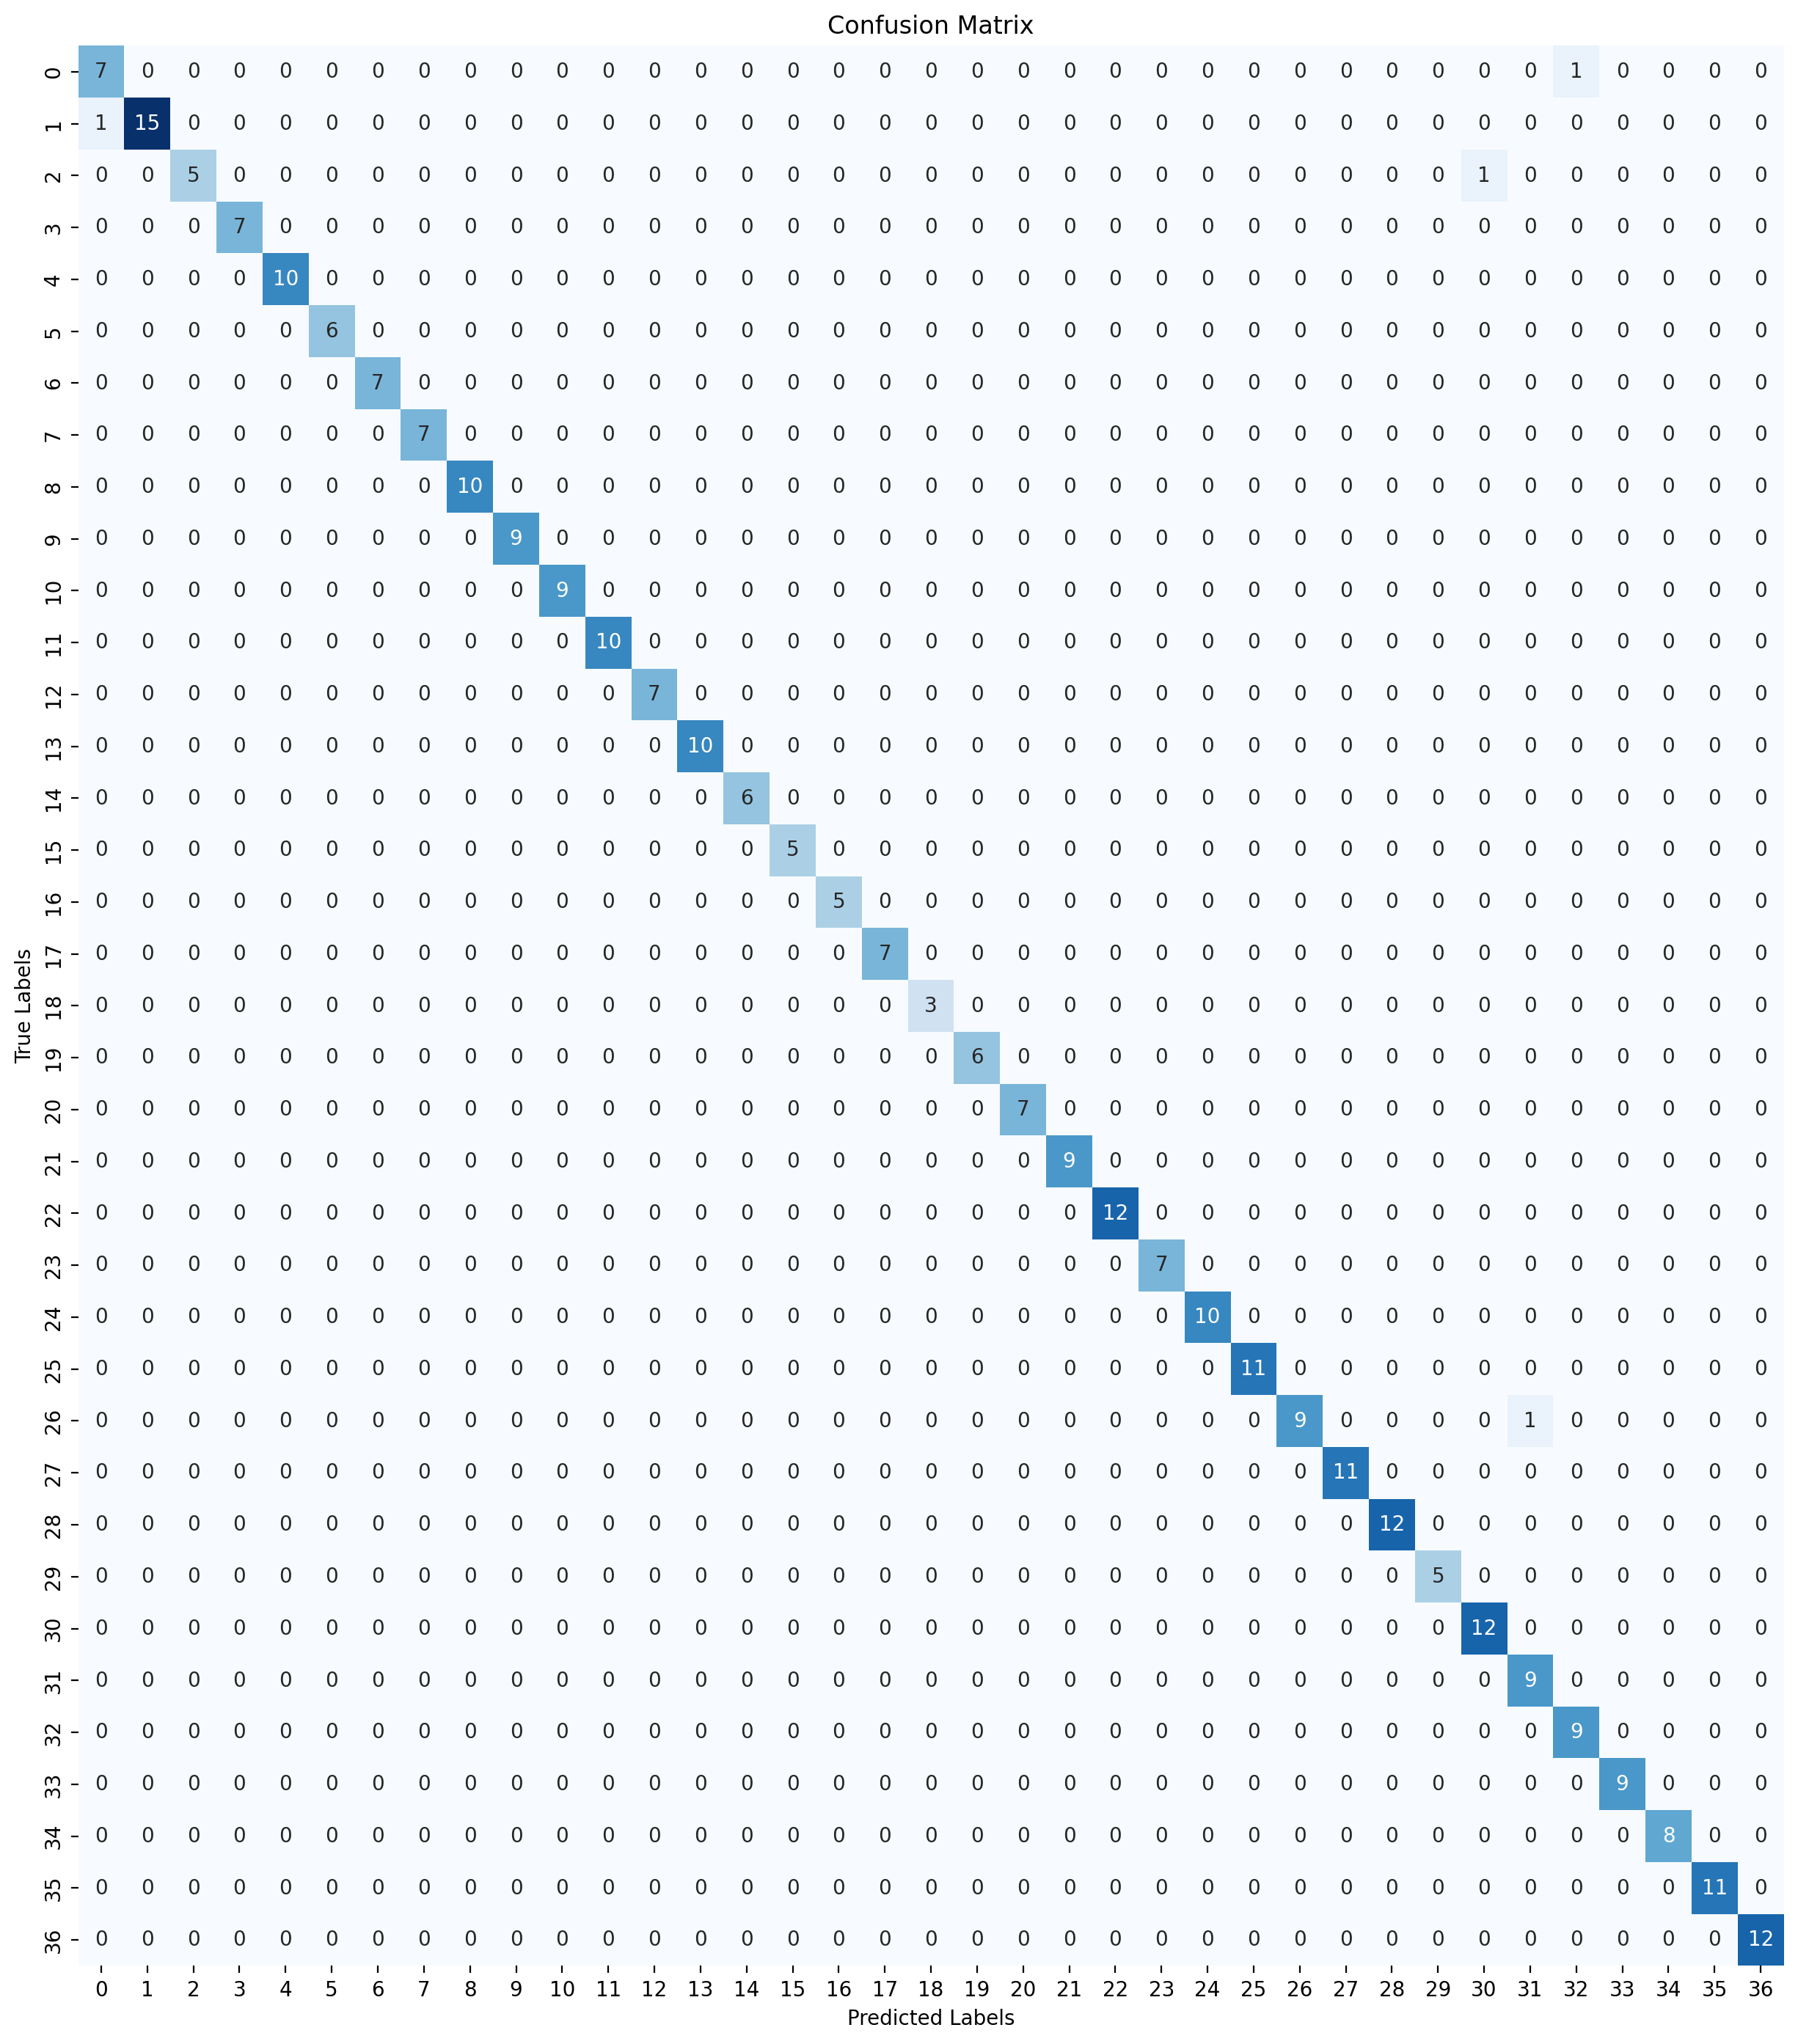

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix 
import seaborn as sns  

predictions = model.predict(x_test)  

predicted_labels = np.argmax(predictions, axis=1)  

true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)  
print(f'Test Accuracy: {accuracy:.3f}')

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(15, 17))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


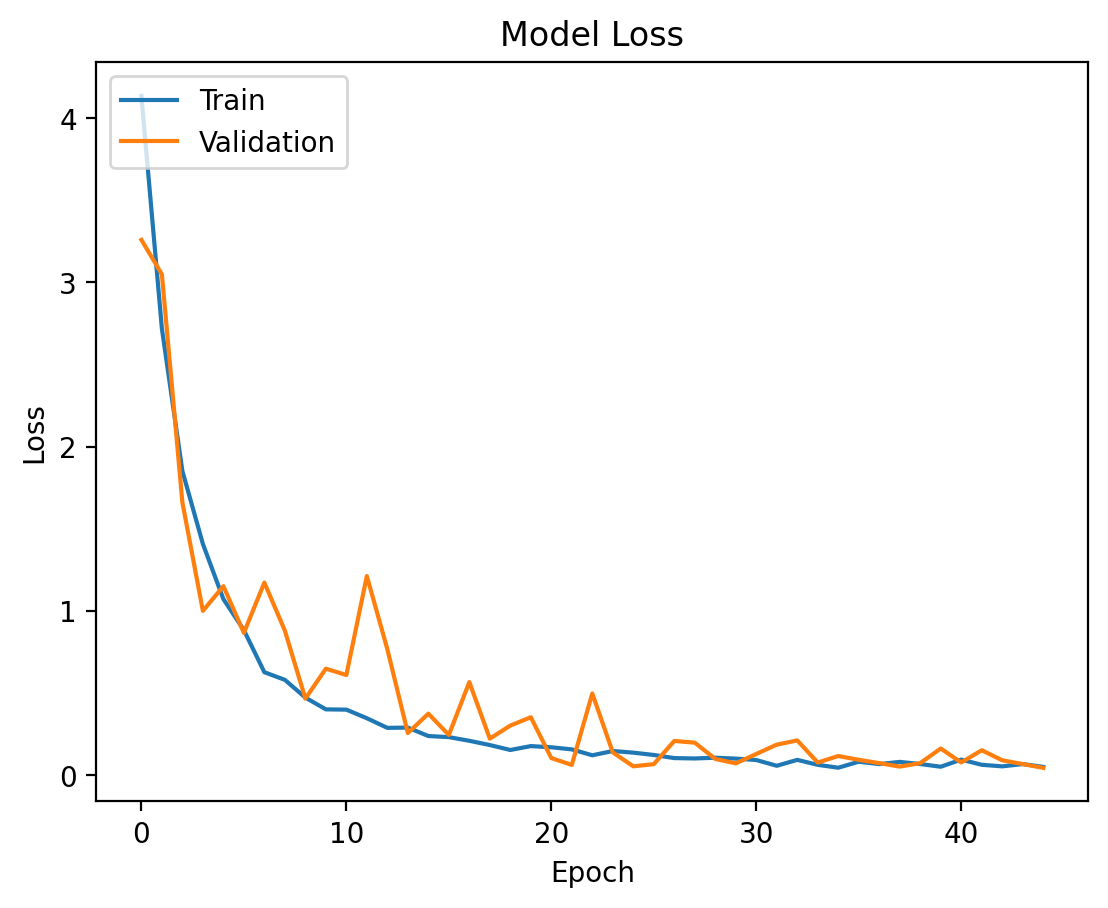

In [38]:
# Plot the training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model and pkl files

In [40]:
# Save the trained model
model.save('guitar_chord_recognition_model.keras', include_optimizer=False)
print("Model saved successfully.")

joblib.dump(encoder, 'encoder.pkl') 
joblib.dump(scaler, 'scaler.pkl')

Model saved successfully.


['scaler.pkl']